# Analyses of the inferred embeddings of the structural regualtors

In this notebook we assess the inferred image embeddings for the previosuly determined structural embeddings. To this end, we will use the embeddings computed during the training of the ResNet ensemble in the 4-fold Group CV setup.

---

## 0. Environmental setup

First, we read in the required software packages and libraries.

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from umap import UMAP
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.cluster import KMeans
from scipy.cluster import hierarchy as hc
from scipy.spatial.distance import pdist, euclidean, cosine
from tqdm import tqdm
from scipy.spatial.distance import squareform
import sys
from sklearn.metrics import (
    mutual_info_score,
    adjusted_mutual_info_score,
    adjusted_rand_score,
    rand_score,
    v_measure_score,
    normalized_mutual_info_score,
)
import matplotlib as mpl
from collections import Counter
from yellowbrick.cluster.elbow import kelbow_visualizer
from yellowbrick.cluster import KElbowVisualizer
from IPython.display import Image
from statannot import add_stat_annotation
import ot

sys.path.append("../../..")
from src.utils.notebooks.ppi.embedding import *
from src.utils.notebooks.images.embedding import *
from src.utils.notebooks.translation.analysis import *
from src.utils.basic.io import get_genesets_from_gmt_file

seed = 1234

%reload_ext nb_black

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [33]:
def assess_cluster_topk(reg_nn_dict, struct_nn_dict, cluster_df):
    struct_topks = []
    reg_topks = []
    samples = []
    for sample in reg_nn_dict.keys():
        reg_nns = reg_nn_dict[sample]
        struct_nns = struct_nn_dict[sample]
        cluster = np.array(cluster_df.loc[sample])[0]
        n_cluster_samples = len(cluster_df.loc[cluster_df.cluster == cluster])
        if n_cluster_samples < 2:
            continue
        samples.append(sample)
        sample_struct_topks = [0]
        sample_reg_topks = [0]
        for i in range(1, len(reg_nns)):
            reg_nn_cluster = np.array(cluster_df.loc[reg_nns[i]])[0]
            struct_nn_cluster = np.array(cluster_df.loc[struct_nns[i]])[0]
            sample_struct_topks.append(
                sample_struct_topks[-1] + int(struct_nn_cluster == cluster)
            )
            sample_reg_topks.append(
                sample_reg_topks[-1] + int(reg_nn_cluster == cluster)
            )
        struct_topks.append(np.array(sample_struct_topks[1:]) / (n_cluster_samples - 1))
        reg_topks.append(np.array(sample_reg_topks[1:]) / (n_cluster_samples - 1))
    return samples, np.array(struct_topks), np.array(reg_topks)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [34]:
def get_neighbor_dict(data, metric="euclidean"):
    samples = np.array(data.index)
    nn = NearestNeighbors(n_neighbors=len(data), metric=metric)
    sample_neighbor_dict = {}
    nn.fit(np.array(data))
    for sample in samples:
        if metric == "precomputed":
            query = np.zeros((1, len(data)))
            query[0, np.where(samples == sample)[0]] = 1
            pred_idx = nn.kneighbors(query, return_distance=False)[0]
        pred_idx = nn.kneighbors(
            np.array(data.loc[sample]).reshape(1, -1), return_distance=False
        )[0]
        sample_neighbor_dict[sample] = samples[pred_idx]
    return sample_neighbor_dict

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [56]:
def get_emd_for_embs(embs, label_col, metric="euclidean"):
    targets = np.unique(embs.loc[:, label_col])
    n_targets = len(targets)
    wd_mtx = np.infty * np.ones((n_targets, n_targets))
    for i in tqdm(range(n_targets), desc="Compute EMD"):
        source = targets[i]
        xs = np.array(embs.loc[embs.loc[:, label_col] == source]._get_numeric_data())
        ns = len(xs)
        ps = np.ones((ns,)) / ns
        for j in range(i, n_targets):
            target = targets[j]
            if source == target:
                wd_st = 0
            else:
                xt = np.array(
                    embs.loc[embs.loc[:, label_col] == target]._get_numeric_data()
                )
                nt = len(xt)
                pt = np.ones((nt,)) / nt
                m = ot.dist(xs, xt, metric=metric)
                m = m / m.max()
                wd_st = ot.sinkhorn2(ps, pt, m, 1)
            wd_mtx[i, j] = wd_st
            wd_mtx[j, i] = wd_st
    wd_df = pd.DataFrame(wd_mtx, columns=list(targets), index=list(targets))
    return wd_df

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

---

## 1. Read in data

Second, we read in the data that describes the latent embeddings of the individual images part of the respective held-out sets in the CV setting.

In [36]:
latents = pd.read_hdf(
    "../../../data/experiments/image_embeddings/specificity_target_emb_loto/EMPTY/20220427_035254/train_latents.h5"
)
print("Read in latent embeddings of shape: {}".format(np.array(latents).shape))

Read in latent embeddings of shape: (86515, 1025)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [37]:
oe_targets = pd.read_csv("../../../data/other/target_lists/covered_oe_targets.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

We will decode the numeric class labels to identify which regulator each embedding corresponds to.

In [38]:
label_dict = {
    "AKT1S1": 0,
    "ATF4": 1,
    "BAX": 2,
    "BCL2L11": 3,
    "BRAF": 4,
    "CASP8": 5,
    "CDC42": 6,
    "CDKN1A": 7,
    "CEBPA": 8,
    "CREB1": 9,
    "CXXC4": 10,
    "DIABLO": 11,
    "E2F1": 12,
    "ELK1": 13,
    "ERG": 14,
    "FGFR3": 15,
    "FOXO1": 16,
    "GLI1": 17,
    "HRAS": 18,
    "IRAK4": 19,
    "JUN": 20,
    "MAP2K3": 21,
    "MAP3K2": 22,
    "MAP3K5": 23,
    "MAP3K9": 24,
    "MAPK7": 25,
    "MOS": 26,
    "MYD88": 27,
    "PIK3R2": 28,
    "PRKACA": 29,
    "PRKCE": 30,
    "RAF1": 31,
    "RELB": 32,
    "RHOA": 33,
    "SMAD4": 34,
    "SMO": 35,
    "SRC": 36,
    "SREBF1": 37,
    "TRAF2": 38,
    "TSC2": 39,
    "WWTR1": 40,
}
label_dict = dict(zip(list(label_dict.values()), list(label_dict.keys())))
latents.loc[:, "labels"] = latents.loc[:, "labels"].map(label_dict)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [39]:
cyto_skeleton_genes = list(
    pd.read_csv(
        "../../../data/other/genesets/kegg_reg_act_cytoskeleton.txt",
        header=None,
        index_col=0,
    ).index
)
cell_cycle_genes = list(
    pd.read_csv(
        "../../../data/other/genesets/reactome_cell_cycle.txt", header=None, index_col=0
    ).index
)
chrom_org_genes = list(
    pd.read_csv(
        "../../../data/other/genesets/reactome_chrom_org.txt", header=None, index_col=0
    ).index
)
dna_repair_genes = list(
    pd.read_csv(
        "../../../data/other/genesets/reactome_dna_repair.txt", header=None, index_col=0
    ).index
)
apoptosis_genes = list(
    pd.read_csv(
        "../../../data/other/genesets/reactome_cell_death.txt", header=None, index_col=0
    ).index
)
human_tfs = list(
    pd.read_csv(
        "../../../data/other/genesets/human_tf_list.txt", header=None, index_col=0
    ).index
)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


To quantitatively assess whether the embeddings of the different folds share a common structure, we cluster each of the inferred latent spaces corresponding to the individual folds individually using agglomerative clustering with average linkage applied to the Wasserstein distances of the induced cell state distributions in the different stages.

Next, we assess the co-clustering for a varying number of clusters (1-30) using the adjusted mutual information between any of the fold-specific embeddings. We expect scores close to 1 especially in proximity to the diagnol of the resulting matrices as this would indicate that the structure of which targets group together in the latent space are the similar between the different inferred latent spaces.

#### 3.1.a. Computing Wasserstein distances

For each fold we will compute a distance matrix that defines the pairwise Wasserstein-2 distances between any overexpression condition in the inferred structural space. To this end, we will use the implementation of the POT package.

##### Fold 0

In [40]:
latents_fold0 = latents.copy()
# latents_fold0.loc[:, "labels"] = latents_fold0.loc[:, "labels"].map(label_dict)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [57]:
wdist_fold0 = get_emd_for_embs(embs=latents_fold0, label_col="labels")

Compute EMD:   0%|          | 0/41 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [58]:
wdist_fold0

,AKT1S1,ATF4,BAX,BCL2L11,BRAF,CASP8,CDC42,CDKN1A,CEBPA,CREB1,...,RAF1,RELB,RHOA,SMAD4,SMO,SRC,SREBF1,TRAF2,TSC2,WWTR1
AKT1S1,0.000000,0.504808,0.526171,0.504432,0.458294,0.537046,0.515441,0.490119,0.540670,0.521401,...,0.501067,0.507869,0.528714,0.535859,0.479497,0.514295,0.512504,0.505443,0.484521,0.500160
ATF4,0.504808,0.000000,0.542425,0.504203,0.505494,0.550733,0.516347,0.500810,0.516684,0.536232,...,0.523475,0.521244,0.544211,0.554357,0.523541,0.547262,0.520563,0.526006,0.494871,0.537794
BAX,0.526171,0.542425,0.000000,0.536687,0.506734,0.573025,0.506505,0.515821,0.538965,0.554515,...,0.521121,0.549101,0.556974,0.516652,0.562255,0.527558,0.555535,0.524929,0.502649,0.561157
BCL2L11,0.504432,0.504203,0.536687,0.000000,0.496446,0.472485,0.522914,0.490548,0.540725,0.529406,...,0.500496,0.501577,0.521368,0.513219,0.520566,0.528960,0.548535,0.498972,0.501885,0.551922
BRAF,0.458294,0.505494,0.506734,0.496446,0.000000,0.516433,0.501165,0.495782,0.492847,0.499702,...,0.491802,0.470655,0.456854,0.510843,0.478521,0.495307,0.474641,0.477276,0.470261,0.466673
CASP8,0.537046,0.550733,0.573025,0.472485,0.516433,0.000000,0.525850,0.497080,0.536859,0.551040,...,0.513665,0.531626,0.517840,0.557762,0.545353,0.552295,0.547791,0.530266,0.508877,0.536803
CDC42,0.515441,0.516347,0.506505,0.522914,0.501165,0.525850,0.000000,0.503122,0.523997,0.496109,...,0.526178,0.510526,0.500083,0.516319,0.536070,0.513020,0.531412,0.516756,0.498572,0.507081
CDKN1A,0.490119,0.500810,0.515821,0.490548,0.495782,0.497080,0.503122,0.000000,0.507441,0.499226,...,0.517503,0.513625,0.508015,0.492982,0.515639,0.509450,0.509606,0.515781,0.480436,0.523587
CEBPA,0.540670,0.516684,0.538965,0.540725,0.492847,0.536859,0.523997,0.507441,0.000000,0.526086,...,0.483273,0.522338,0.528430,0.558782,0.535002,0.529305,0.559931,0.519248,0.497385,0.548508
CREB1,0.521401,0.536232,0.554515,0.529406,0.499702,0.551040,0.496109,0.499226,0.526086,0.000000,...,0.494074,0.532402,0.542361,0.509794,0.548554,0.539935,0.530530,0.513737,0.526639,0.561066


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

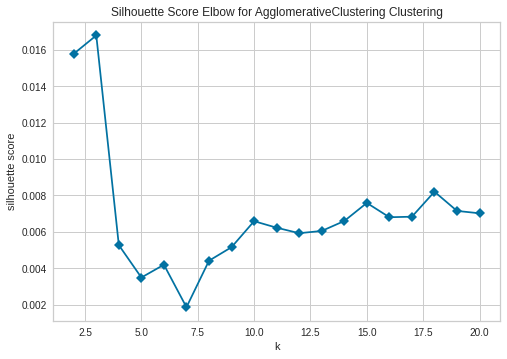

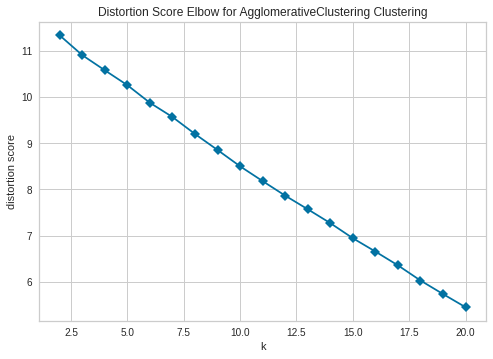

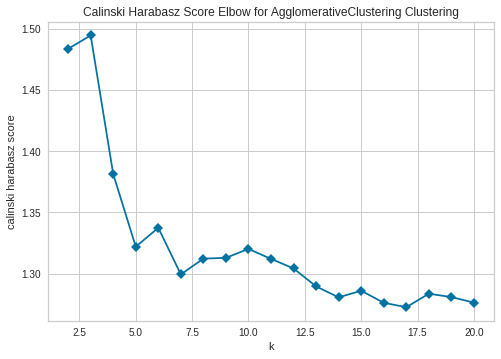

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [59]:
model = AgglomerativeClustering(affinity="precomputed", linkage="complete")
# model = KMeans(random_state=1234)
visualizer = KElbowVisualizer(
    model, k=20, metric="silhouette", timings=False, locate_elbow=False
)

visualizer.fit(wdist_fold0)
ax = visualizer.show()

visualizer = KElbowVisualizer(
    model, k=20, metric="distortion", timings=False, locate_elbow=False
)

visualizer.fit(wdist_fold0)
ax = visualizer.show()

visualizer = KElbowVisualizer(
    model, k=20, metric="calinski_harabasz", timings=False, locate_elbow=False
)

visualizer.fit(wdist_fold0)
ax = visualizer.show()

In [60]:
model = AgglomerativeClustering(
    n_clusters=4, affinity="precomputed", linkage="complete"
)
struct_cluster_labels = model.fit_predict(wdist_fold0)
struct_clusters = pd.DataFrame(
    struct_cluster_labels,
    index=wdist_fold0.index,
    columns=["cluster"],
)
lut = dict(
    zip(
        list(np.unique(struct_cluster_labels)),
        [
            "tab:blue",
            "tab:red",
            "tab:green",
            "tab:orange",
            "tab:pink",
            "tab:purple",
            "tab:brown",
            "tab:gray",
            "tab:olive",
            "tab:cyan",
        ],
    )
)
struct_colors = pd.Series(
    struct_cluster_labels,
    index=wdist_fold0.index,
).map(lut)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Wasserstein distance matrix of the structural space (fold 0)


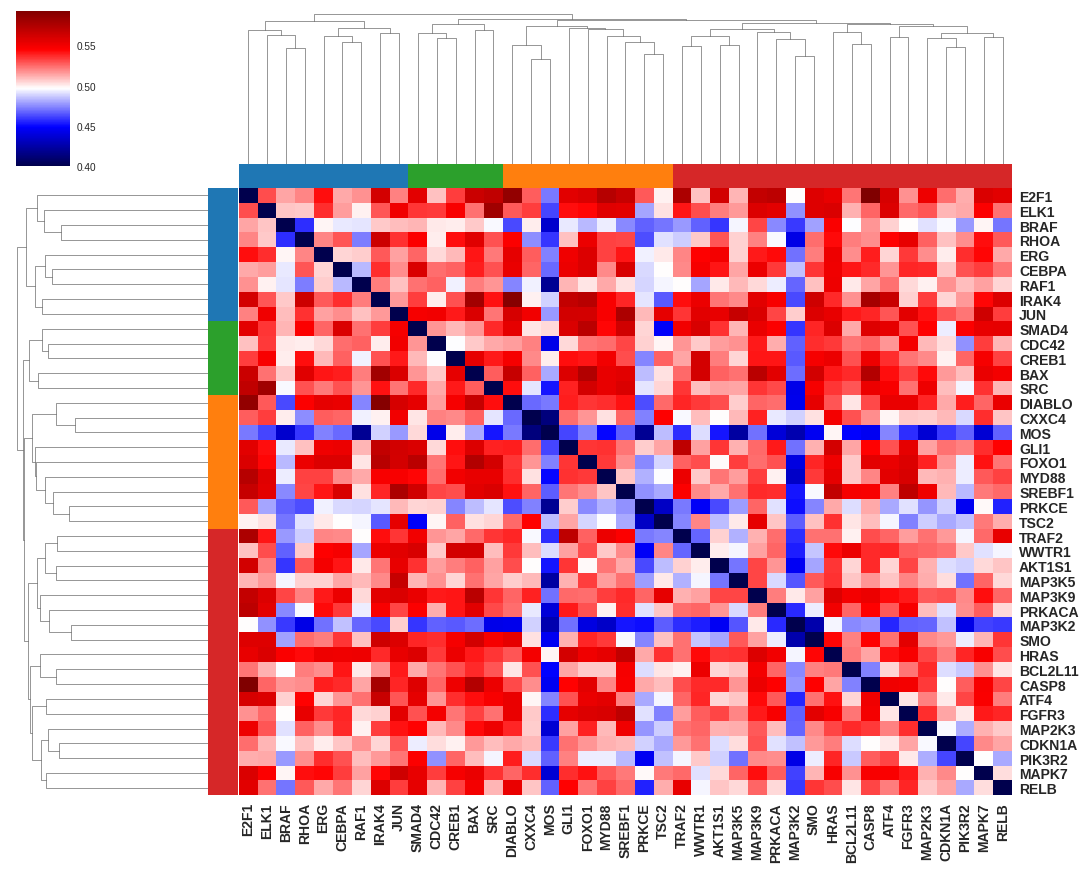

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [63]:
linkage = hc.linkage(squareform(wdist_fold0), method="complete")
ax = sns.clustermap(
    wdist_fold0,
    row_linkage=linkage,
    col_linkage=linkage,
    figsize=[15, 12],
    cmap="seismic",
    vmin=0.4,
    col_colors=np.array(struct_colors),
    row_colors=np.array(struct_colors),
)
ax.ax_heatmap.set_xticklabels(
    ax.ax_heatmap.get_xmajorticklabels(), fontsize=14, fontweight="bold"
)
ax.ax_heatmap.set_yticklabels(
    ax.ax_heatmap.get_ymajorticklabels(), fontsize=14, fontweight="bold"
)
print("Wasserstein distance matrix of the structural space (fold 0)")
plt.show()

---

##### Fold 1

In [178]:
latents_fold1 = all_latents[1].copy()
latents_fold1.loc[:, "labels"] = latents_fold1.loc[:, "labels"].map(label_dict)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [105]:
wdist_fold1 = get_emd_for_embs(embs=latents_fold1, label_col="labels")

Compute EMD: 100%|██████████| 42/42 [02:56<00:00,  4.21s/it]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Wasserstein distance matrix of the structural space (fold 1)


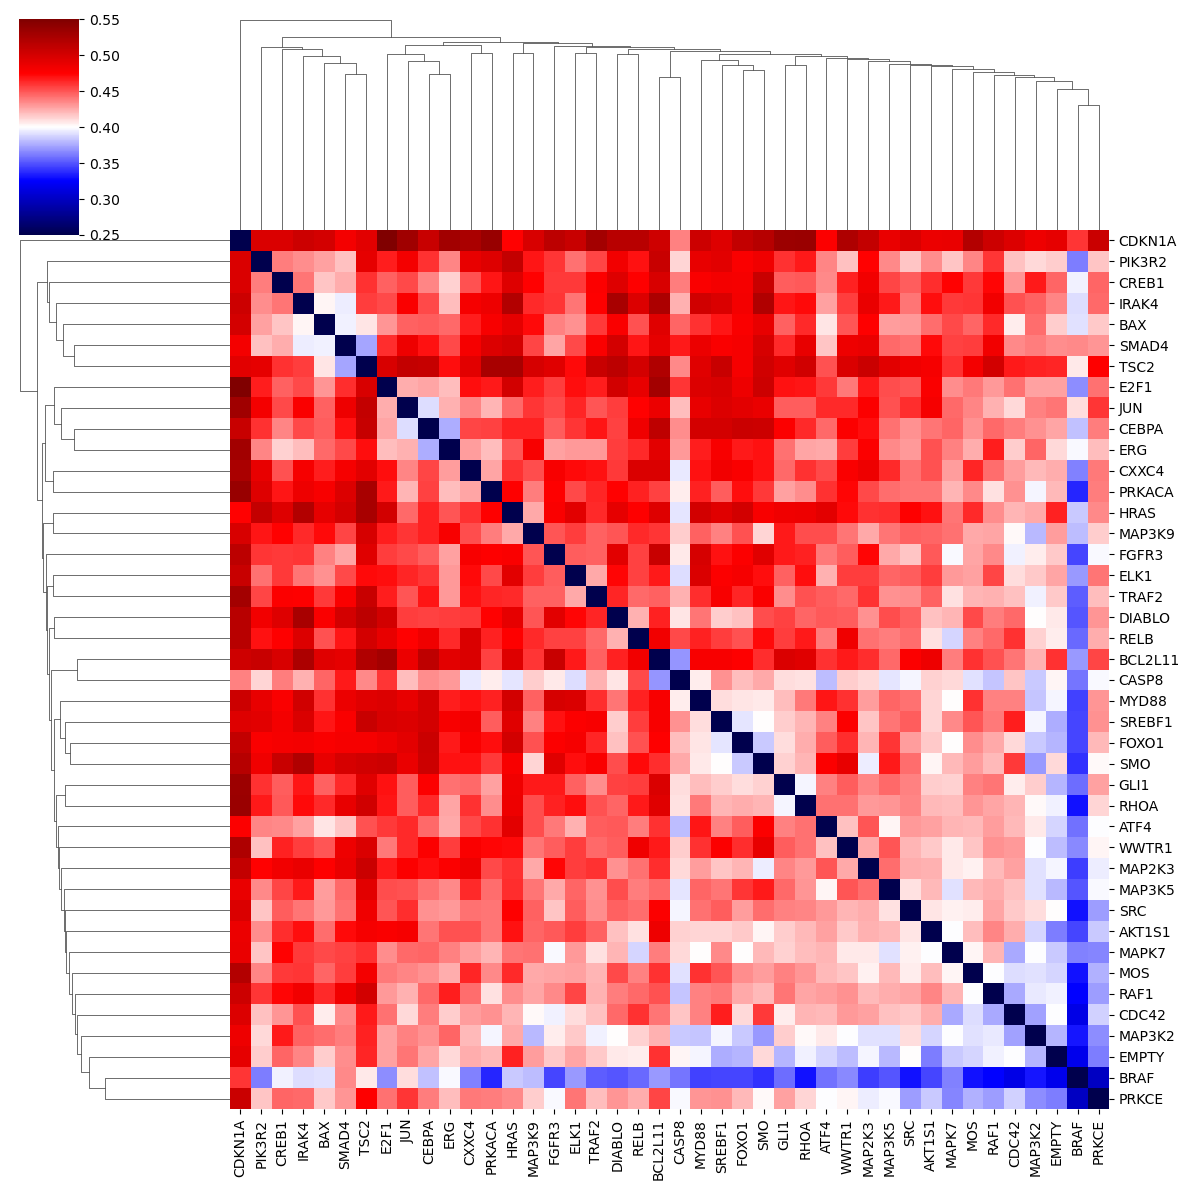

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [410]:
linkage = hc.linkage(squareform(wdist_fold1), method="average")
ax = sns.clustermap(
    wdist_fold1,
    row_linkage=linkage,
    col_linkage=linkage,
    figsize=[12, 12],
    cmap="seismic",
    vmin=0.25,
)
print("Wasserstein distance matrix of the structural space (fold 1)")
plt.show()

---

##### Fold 2

In [107]:
latents_fold2 = all_latents[2].copy()
latents_fold2.loc[:, "labels"] = latents_fold2.loc[:, "labels"].map(label_dict)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [108]:
wdist_fold2 = get_emd_for_embs(embs=latents_fold2, label_col="labels")

Compute EMD: 100%|██████████| 42/42 [02:56<00:00,  4.19s/it]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Wasserstein distance matrix of the structural space (fold 2)


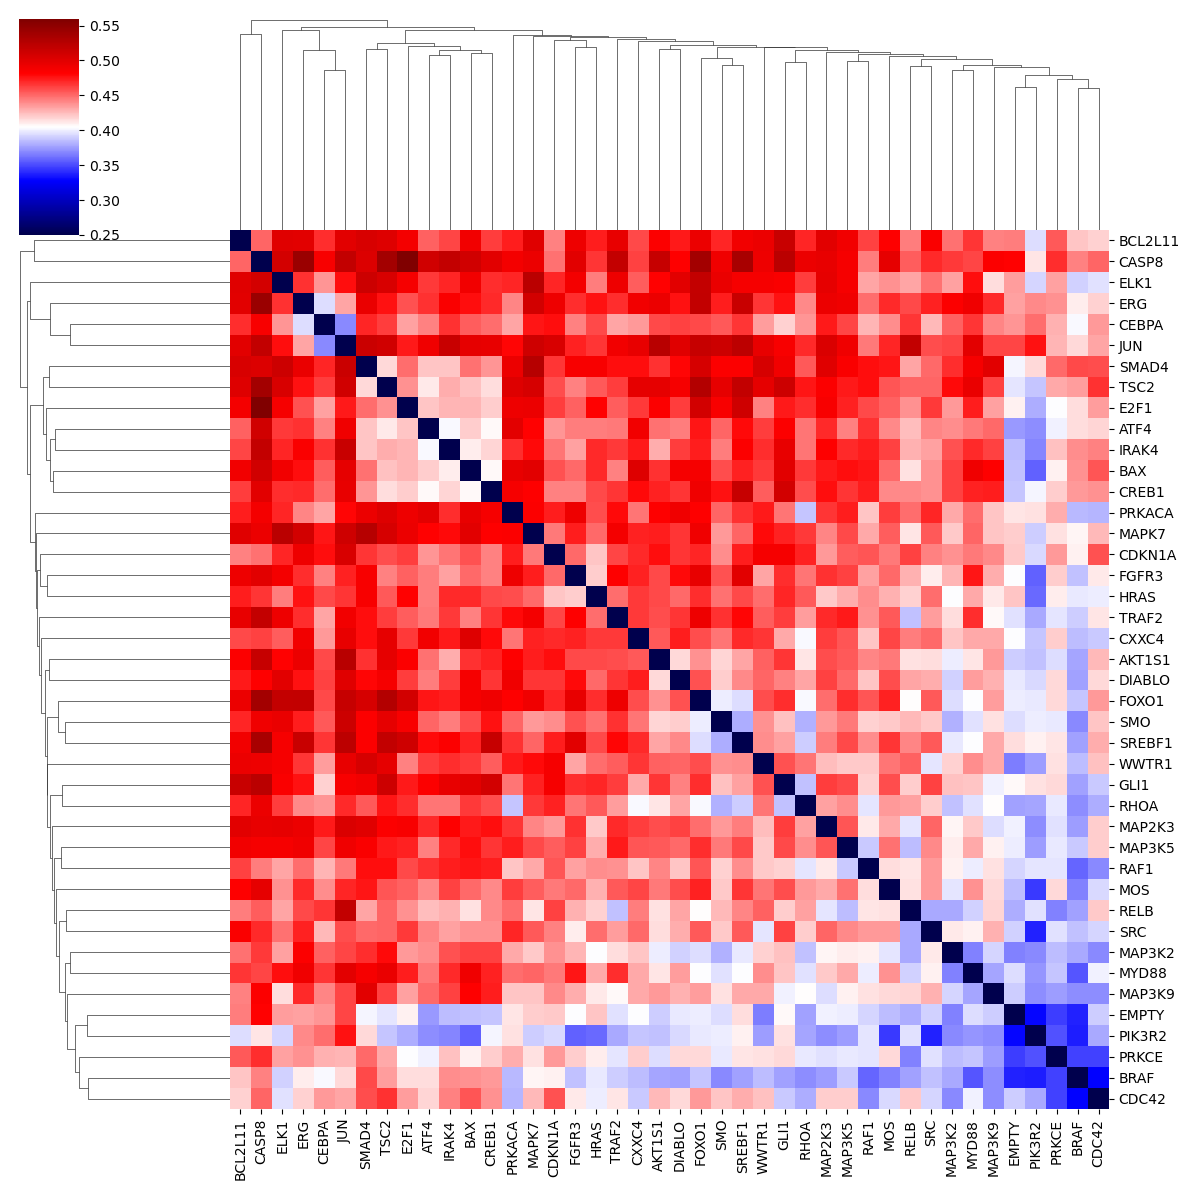

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [411]:
linkage = hc.linkage(squareform(wdist_fold2), method="average")
ax = sns.clustermap(
    wdist_fold2,
    row_linkage=linkage,
    col_linkage=linkage,
    figsize=[12, 12],
    cmap="seismic",
    vmin=0.25,
)
print("Wasserstein distance matrix of the structural space (fold 2)")
plt.show()

---

##### Fold 3

In [110]:
latents_fold3 = all_latents[3].copy()
latents_fold3.loc[:, "labels"] = latents_fold3.loc[:, "labels"].map(label_dict)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [111]:
wdist_fold3 = get_emd_for_embs(embs=latents_fold3, label_col="labels")

Compute EMD: 100%|██████████| 42/42 [02:54<00:00,  4.16s/it]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Wasserstein distance matrix of the structural space (fold 3)


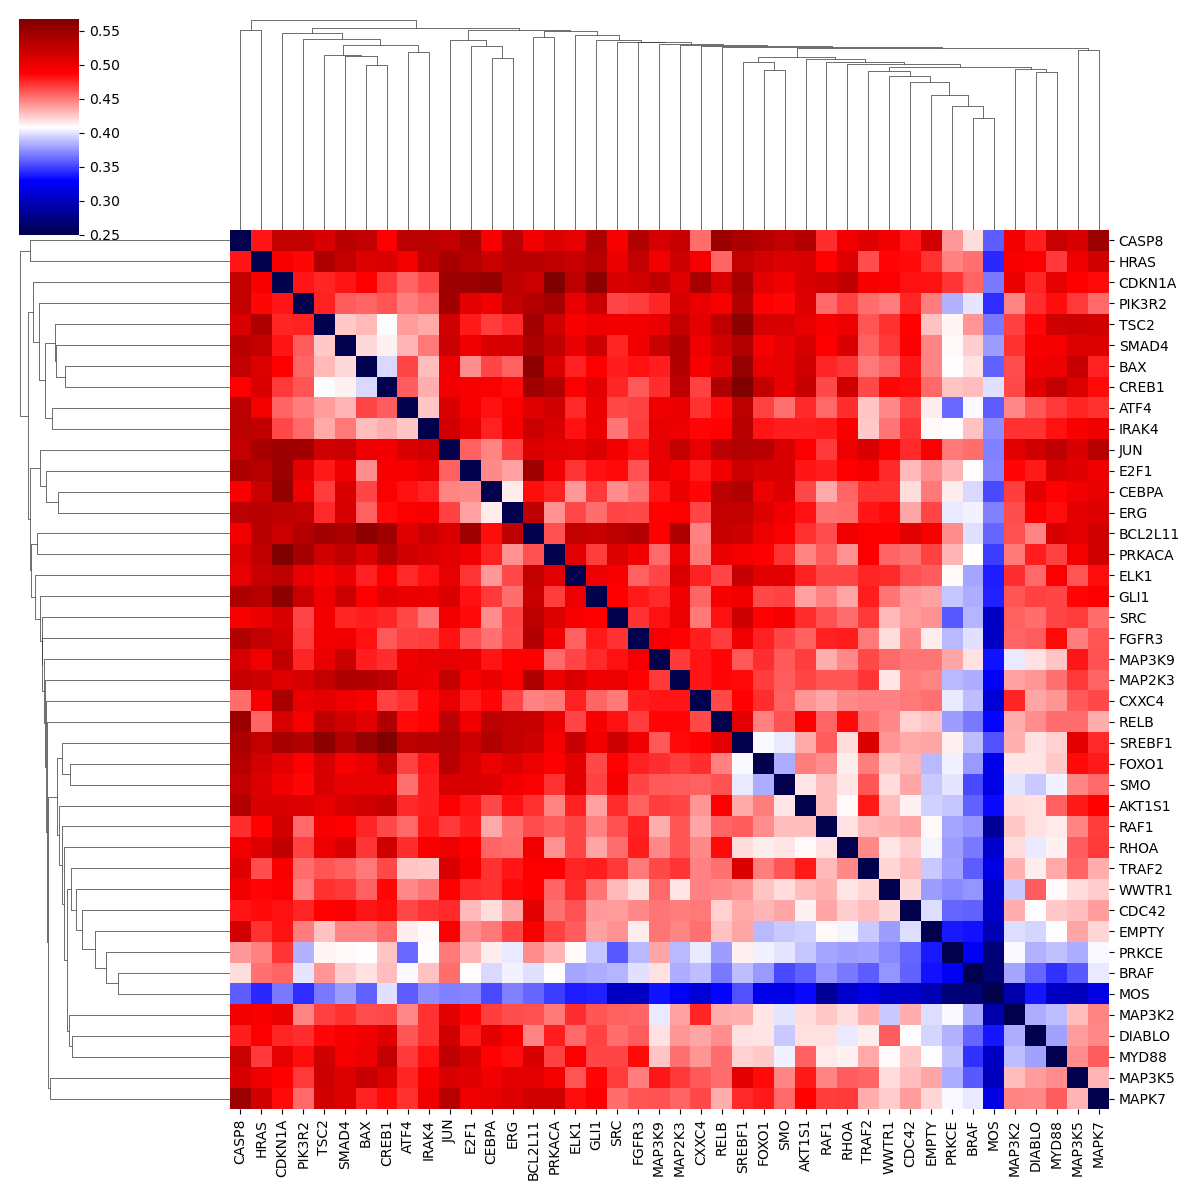

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [412]:
linkage = hc.linkage(squareform(wdist_fold3), method="average")
ax = sns.clustermap(
    wdist_fold3,
    row_linkage=linkage,
    col_linkage=linkage,
    figsize=[12, 12],
    cmap="seismic",
    vmin=0.25,
)
print("Wasserstein distance matrix of the structural space (fold 3)")
plt.show()

---

#### 3.1.b. Co-cluster analysis

To better assess the structural differences in the inferred physical spaces for the different held-out folds, we co-cluster structure the different latent spaces hierarchically using average linkage and the pre-computed Wasserstein distances.

##### Average linkage clustering

In [126]:
avg_amis = []
names = []
wdists = [wdist_fold0, wdist_fold1, wdist_fold2, wdist_fold3]
for i in tqdm(range(len(wdists))):
    names.append("fold_{}".format(i))
    for j in range(len(wdists)):
        avg_amis.append(
            compute_ami_matrix(
                wdists[i],
                wdists[j],
                affinity="precomputed",
                n_max_clusters=30,
                linkage="average",
            )
        )

100%|██████████| 4/4 [00:37<00:00,  9.26s/it]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

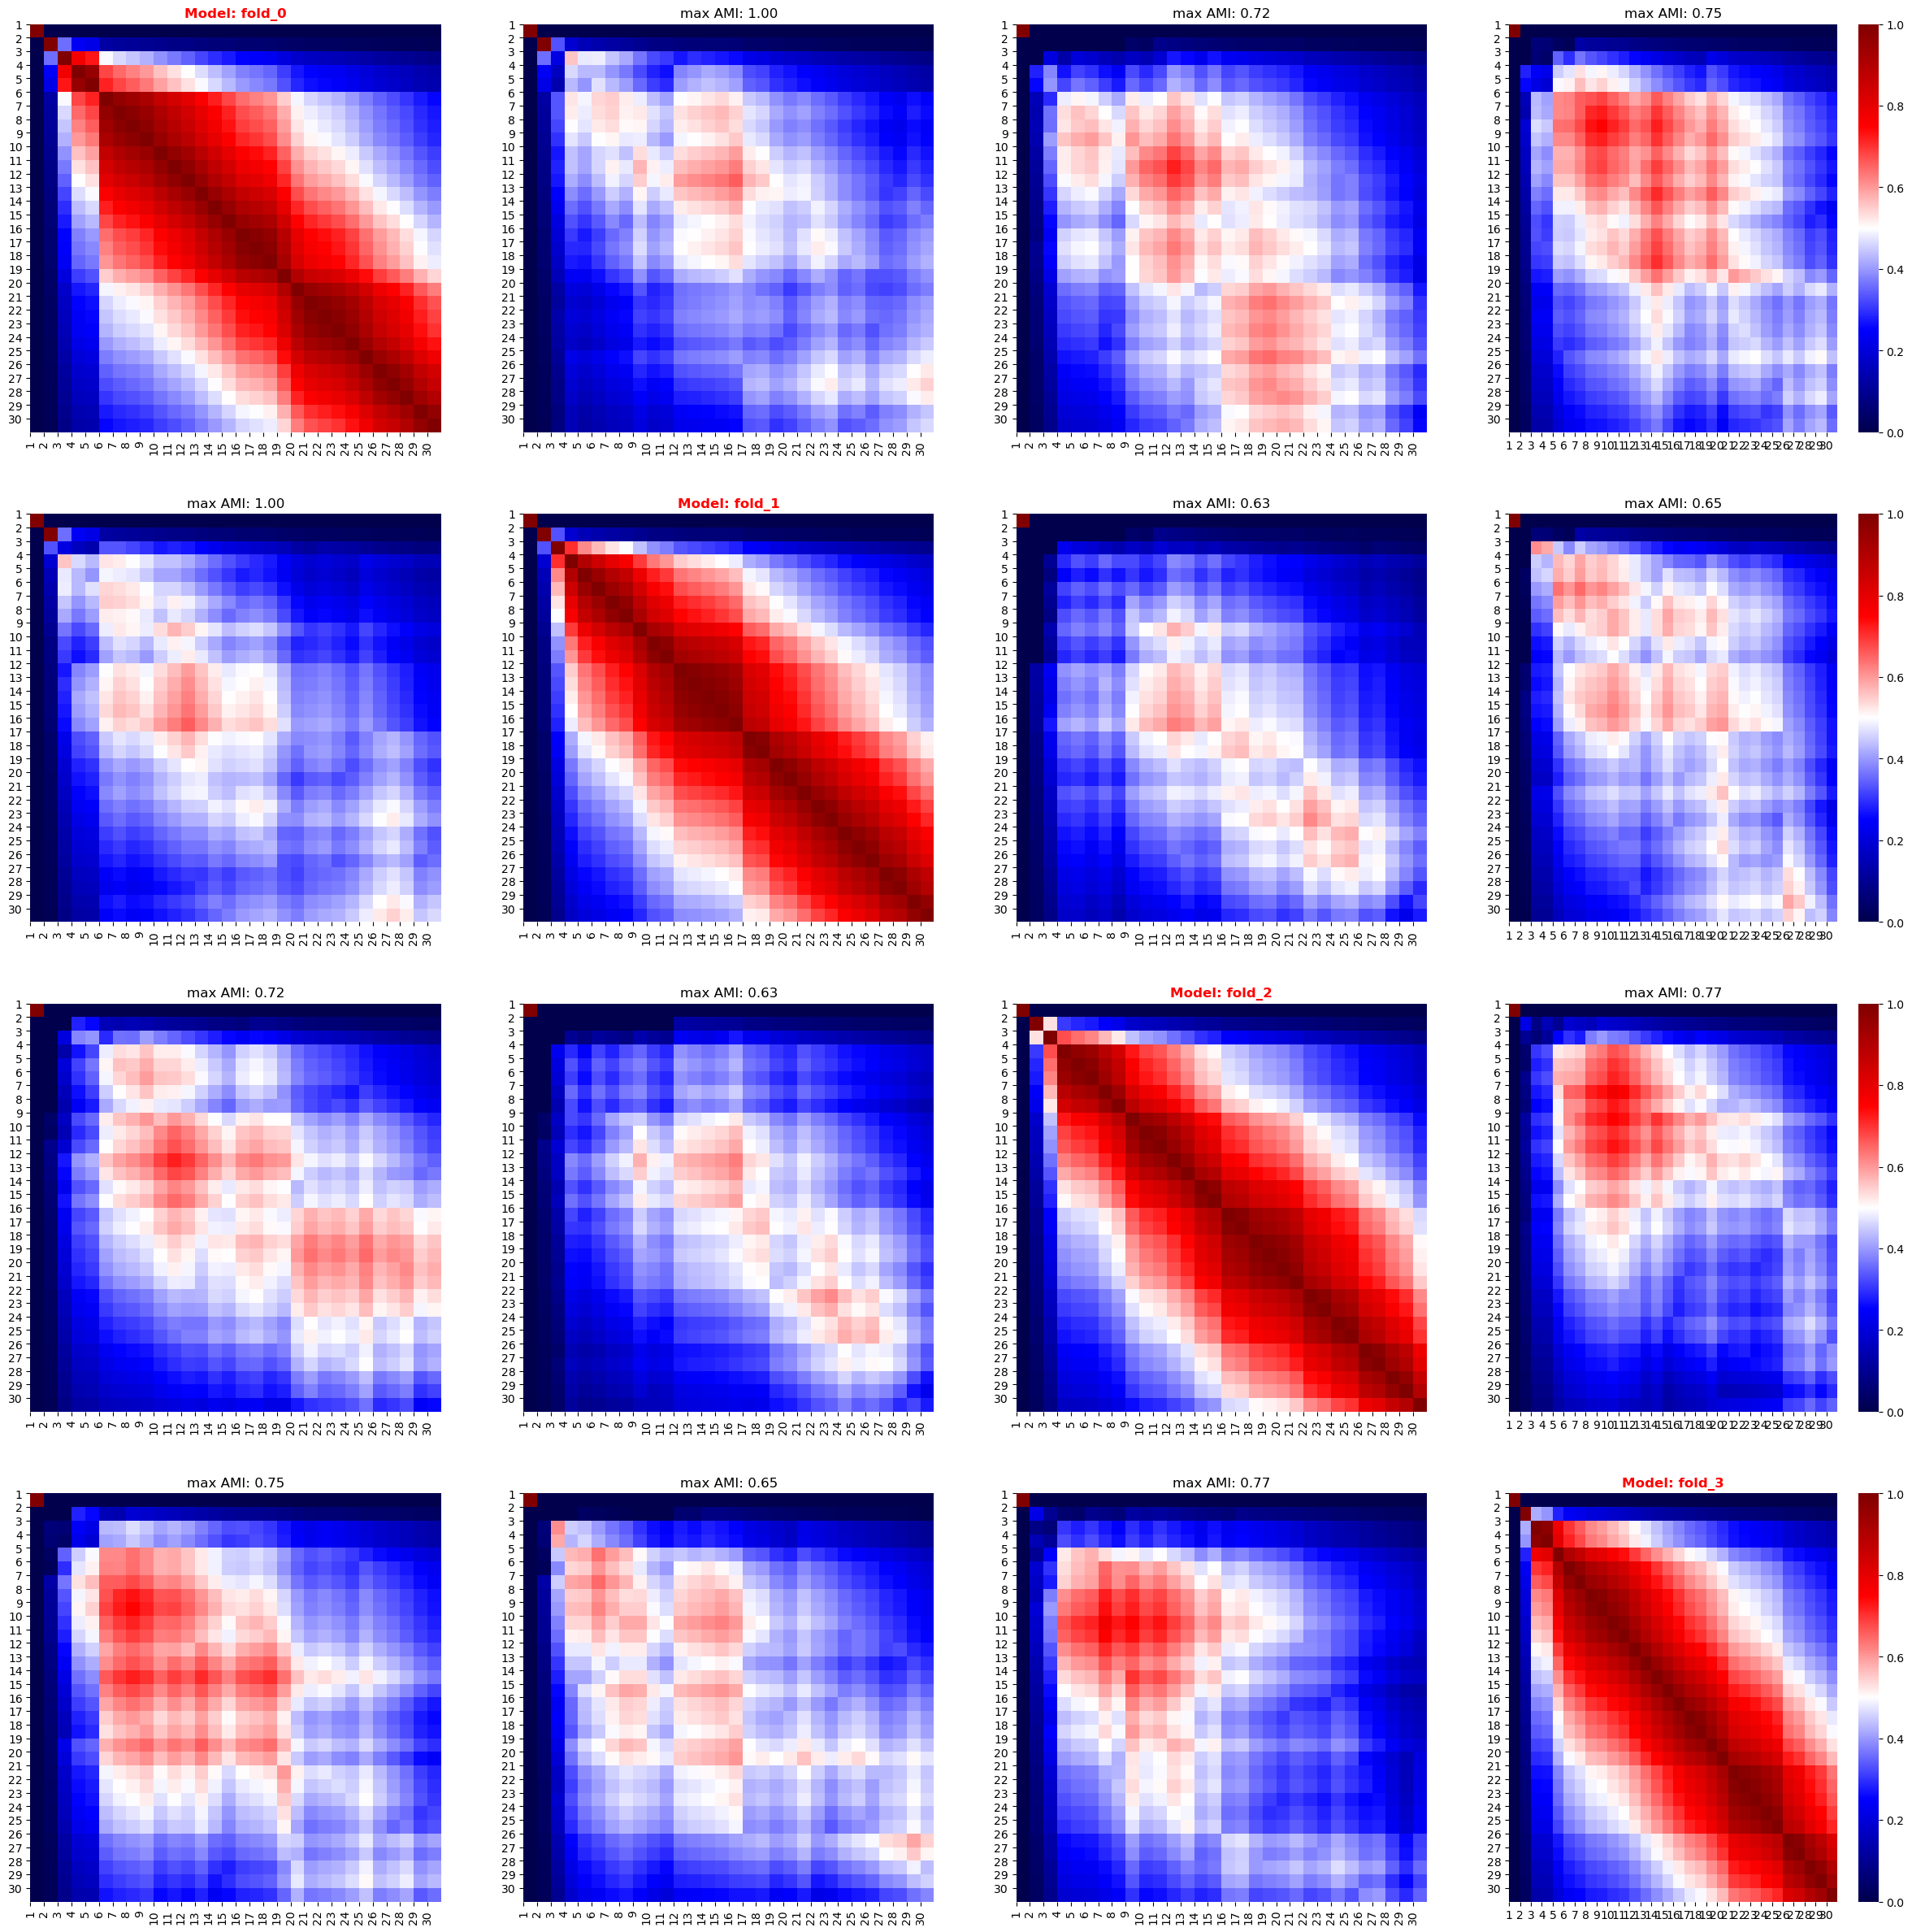

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [127]:
plot_amis_matrices(names, avg_amis)

The above plots suggest a fair heterogeneity between the differently inferred spaces which is likely due to the relatively small sample size with respect to the observed heterogeneity in the response of the cells for some of the conditions.

---

### 3.2. Individual cluster analyses

After having assessed the shared structure between the different fold embeddings, we now will look at each fold individually and aim to better understand the observed cluster of those.

#### 3.2.a. EMD-based clustering

To this end, we will first cluster each fold embedding hierarchicallly using euclidean distances and average/complete linkage. We will thereby describe each gene embedding by the mean embedding of the individual cells where the corresponding gene was targeted.

---

#### Fold 0

We cluster the inferred physical space as before using hierarchical clustering with average linkage on the pre-computed Wasserstein distances. To identify the optimal number of clusters, we look at three commonly used metrics namely the Silhouette, distortion and Calinski-Harabasz score.

In [134]:
model = AgglomerativeClustering(affinity="precomputed", linkage="average")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

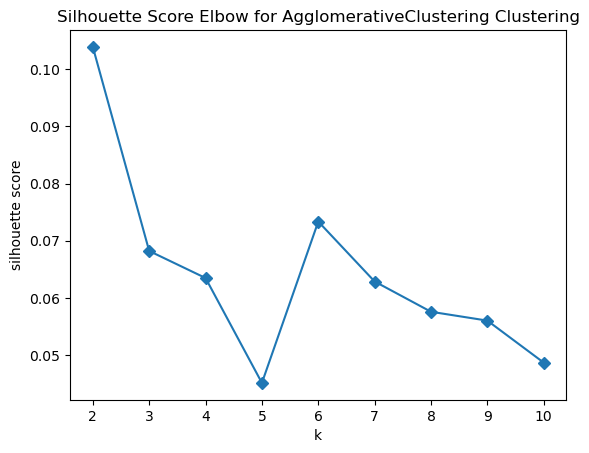

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [135]:
visualizer = KElbowVisualizer(
    model, k=10, metric="silhouette", timings=False, locate_elbow=False
)

visualizer.fit(wdist_fold0)
ax = visualizer.show()

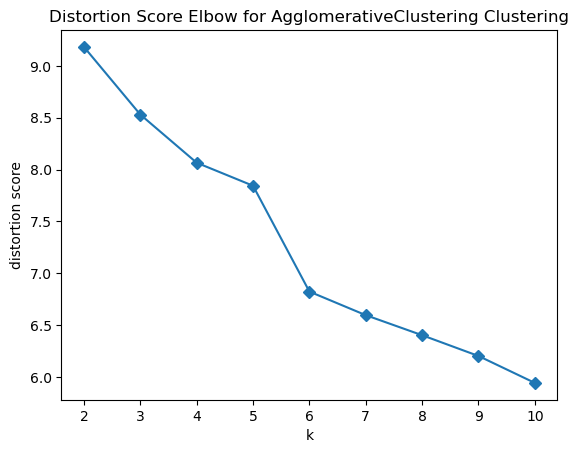

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [136]:
visualizer = KElbowVisualizer(
    model, k=10, metric="distortion", timings=False, locate_elbow=False
)

visualizer.fit(wdist_fold0)
ax = visualizer.show()

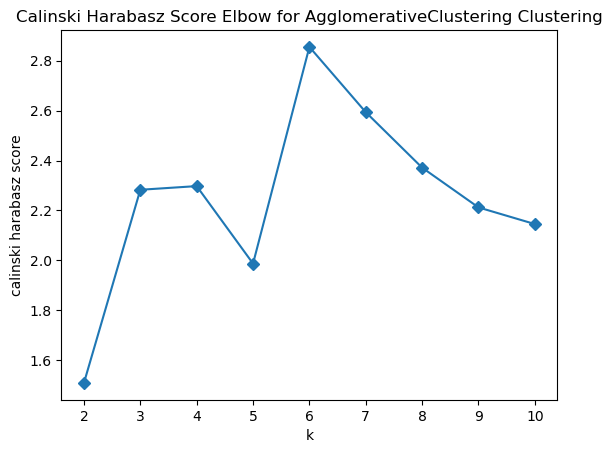

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [138]:
visualizer = KElbowVisualizer(
    model, k=10, metric="calinski_harabasz", timings=False, locate_elbow=False
)

visualizer.fit(wdist_fold0)
ax = visualizer.show()

The plots above indicate that a clustering solution of 6 clusters might be optimal as it maximizes the Calinski-Harabsz score, is a local optima of the Silhoutte score and roughly coincides with the elbow of the distortion score. Thus, we decide to use 6 clusters.

In [382]:
model = AgglomerativeClustering(
    n_clusters=6, affinity="precomputed", linkage="complete"
)
cluster_labels = model.fit_predict(wdist_fold0)
cluster_dict = {}
for cluster_label in np.unique(cluster_labels):
    cluster_dict[cluster_label] = list(
        np.array(list(wdist_fold0.index))[cluster_labels == cluster_label]
    )
for k, v in cluster_dict.items():
    print("Cluster {}: {}".format(k, v))
    print("")

Cluster 0: ['CEBPA', 'CXXC4', 'E2F1', 'ERG', 'JUN']

Cluster 1: ['EMPTY', 'FGFR3', 'MAP3K5', 'MAPK7', 'MOS', 'PIK3R2', 'PRKCE', 'RELB', 'SRC', 'TRAF2', 'WWTR1']

Cluster 2: ['ATF4', 'BAX', 'CREB1', 'ELK1', 'IRAK4', 'SMAD4', 'TSC2']

Cluster 3: ['AKT1S1', 'BRAF', 'CDC42', 'DIABLO', 'FOXO1', 'GLI1', 'MAP2K3', 'MAP3K2', 'MAP3K9', 'MYD88', 'PRKACA', 'RAF1', 'RHOA', 'SMO', 'SREBF1']

Cluster 4: ['CDKN1A']

Cluster 5: ['BCL2L11', 'CASP8', 'HRAS']



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

To visualize the clustering, we plot the mean embeddings for each target in a tSNE plot colored by the different identified clusters.

In [383]:
mean_fold0_latents = latents_fold0.groupby("labels").mean()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [394]:
reg_embs_clusters = pd.read_csv(
    "../../../data/ppi/embedding/node_embeddings_cv_1024_2gexrecon_1graph_recon_mask_loss_newnodeset_clusters.csv",
    index_col=0,
)
cluster_labels = np.array(reg_embs_clusters.loc[shared_nodes]).ravel()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/home/paysan_d/miniconda3/envs/image2reg/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


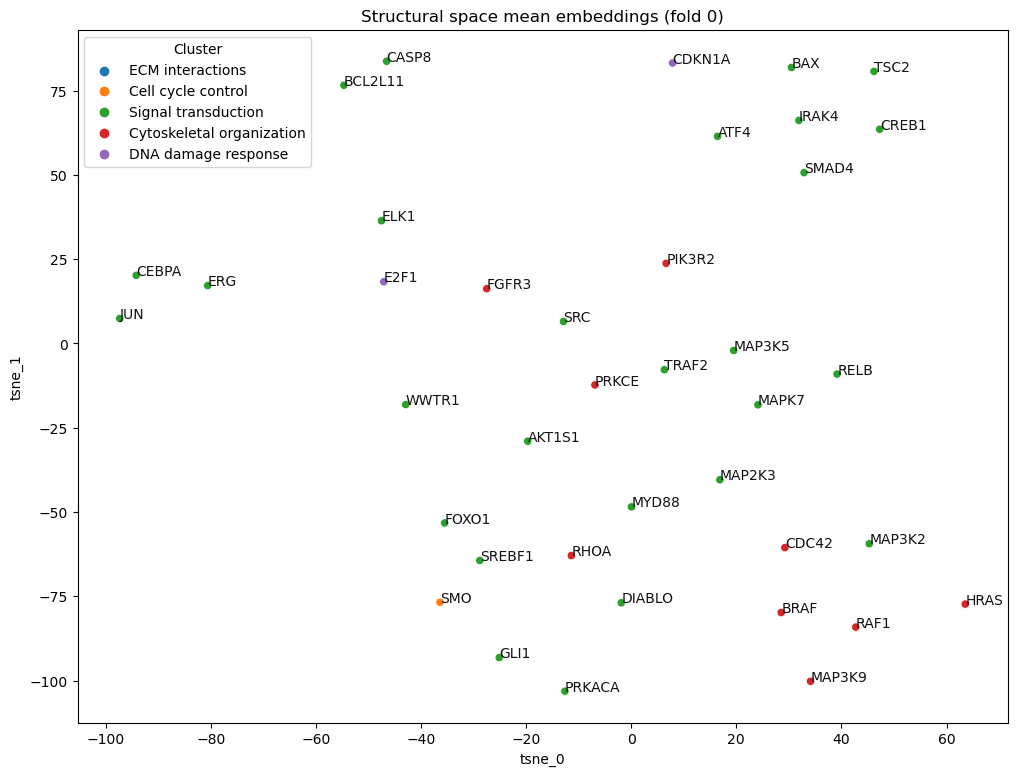

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [402]:
fig, ax = plt.subplots(figsize=[12, 9])
ax = plot_tsne_embs(
    mean_fold0_latents.loc[shared_nodes],
    ax=ax,
    perplexity=8,
    random_state=1234,
    hue=np.array(cluster_labels).astype(str),
    hue_order=[
        "ECM interactions",
        "Cell cycle control",
        "Signal transduction",
        "Cytoskeletal organization",
        "DNA damage response",
    ],
    palette={
        "ECM interactions": "tab:blue",
        "Cell cycle control": "tab:orange",
        "Signal transduction": "tab:green",
        "Cytoskeletal organization": "tab:red",
        "DNA damage response": "tab:purple",
    },
)
ax.set_title("Structural space mean embeddings (fold 0)")
ax.legend(title="Cluster", loc="upper left")
# ax.set_xlim([-40, 50])
plt.show()

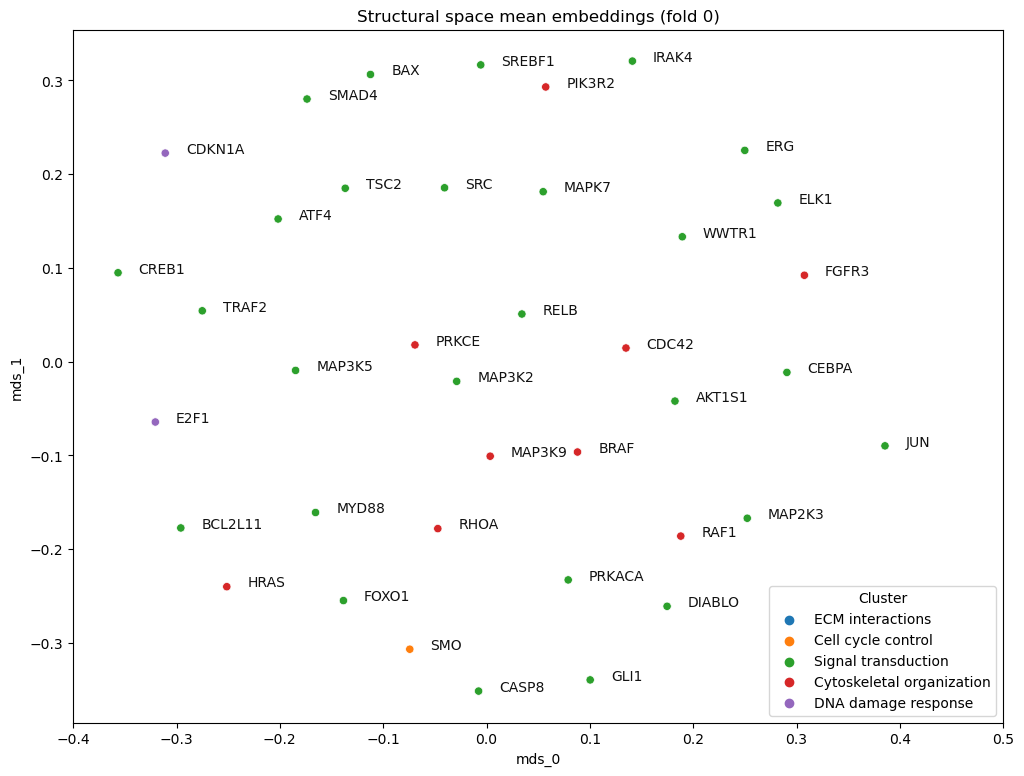

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [407]:
fig, ax = plt.subplots(figsize=[12, 9])
ax = plot_mds_embs(
    wdist_fold0.loc[shared_nodes, shared_nodes],
    ax=ax,
    dissimilarity="precomputed",
    hue=np.array(cluster_labels).astype(str),
    hue_order=[
        "ECM interactions",
        "Cell cycle control",
        "Signal transduction",
        "Cytoskeletal organization",
        "DNA damage response",
    ],
    palette={
        "ECM interactions": "tab:blue",
        "Cell cycle control": "tab:orange",
        "Signal transduction": "tab:green",
        "Cytoskeletal organization": "tab:red",
        "DNA damage response": "tab:purple",
    },
)
ax.set_title("Structural space mean embeddings (fold 0)")
ax.legend(title="Cluster", loc="lower right")
ax.set_xlim([-0.4, 0.5])
plt.show()

---

##### Fold 1

We repeat the above process for the other folds as well.

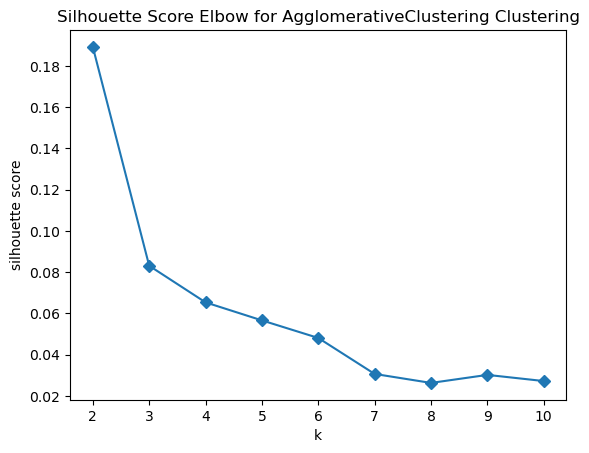

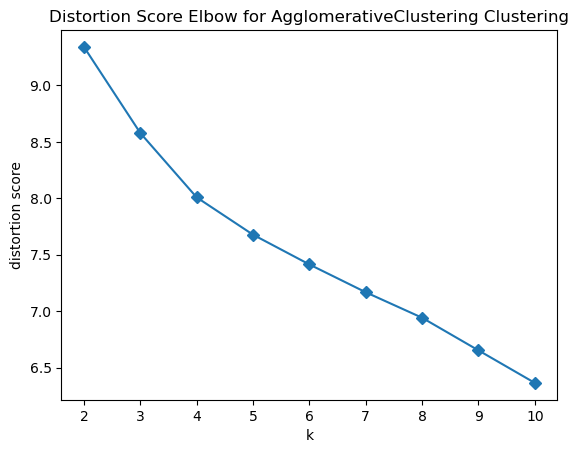

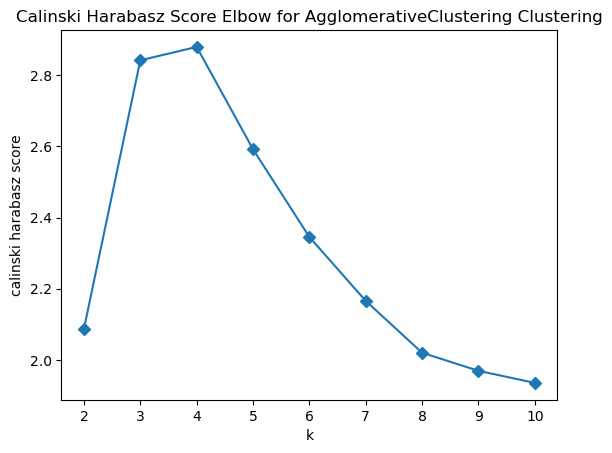

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [167]:
model = AgglomerativeClustering(affinity="precomputed", linkage="average")
visualizer = KElbowVisualizer(
    model, k=10, metric="silhouette", timings=False, locate_elbow=False
)

visualizer.fit(wdist_fold1)
ax = visualizer.show()

visualizer = KElbowVisualizer(
    model, k=10, metric="distortion", timings=False, locate_elbow=False
)

visualizer.fit(wdist_fold1)
ax = visualizer.show()

visualizer = KElbowVisualizer(
    model, k=10, metric="calinski_harabasz", timings=False, locate_elbow=False
)

visualizer.fit(wdist_fold1)
ax = visualizer.show()

We find the optimal number of clusters to be four as this solution maximizes the Calinski-Harabasz score.

In [209]:
model = AgglomerativeClustering(n_clusters=4, affinity="precomputed", linkage="average")
cluster_labels = model.fit_predict(wdist_fold1)
cluster_dict = {}
for cluster_label in np.unique(cluster_labels):
    cluster_dict[cluster_label] = list(
        np.array(list(wdist_fold0.index))[cluster_labels == cluster_label]
    )
for k, v in cluster_dict.items():
    print("Cluster {}: {}".format(k, v))
    print("")

Cluster 0: ['AKT1S1', 'ATF4', 'BCL2L11', 'BRAF', 'CASP8', 'CDC42', 'DIABLO', 'ELK1', 'EMPTY', 'FGFR3', 'FOXO1', 'GLI1', 'HRAS', 'MAP2K3', 'MAP3K2', 'MAP3K5', 'MAP3K9', 'MAPK7', 'MOS', 'MYD88', 'PRKCE', 'RAF1', 'RELB', 'RHOA', 'SMO', 'SRC', 'SREBF1', 'TRAF2', 'WWTR1']

Cluster 1: ['CEBPA', 'CXXC4', 'E2F1', 'ERG', 'JUN', 'PRKACA']

Cluster 2: ['BAX', 'CREB1', 'IRAK4', 'PIK3R2', 'SMAD4', 'TSC2']

Cluster 3: ['CDKN1A']



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/home/paysan_d/miniconda3/envs/image2reg/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


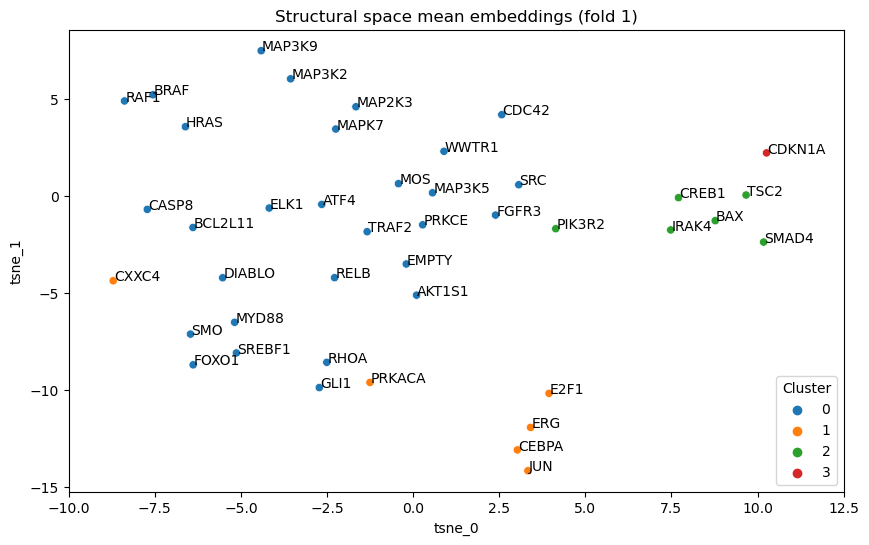

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [210]:
mean_fold1_latents = latents_fold1.groupby("labels").mean()
fig, ax = plt.subplots(figsize=[10, 6])
ax = plot_tsne_embs(
    mean_fold1_latents,
    ax=ax,
    perplexity=10,
    random_state=1234,
    hue=np.array(cluster_labels).astype(str),
    hue_order=np.unique(cluster_labels).astype(str),
)
ax.set_title("Structural space mean embeddings (fold 1)")
ax.set_xlim([-10, 12.5])
ax.legend(title="Cluster", loc="lower right")
plt.show()

---

##### Fold 2

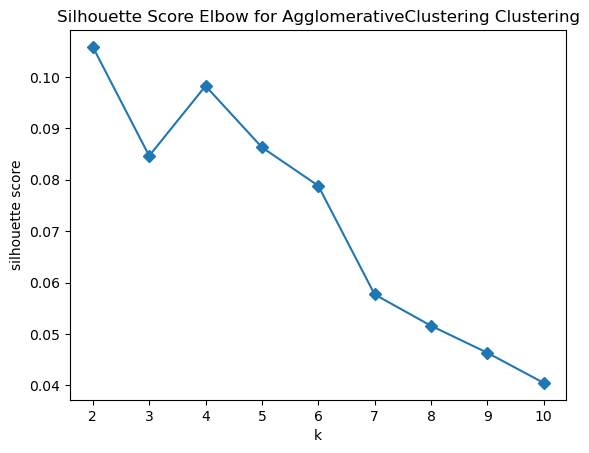

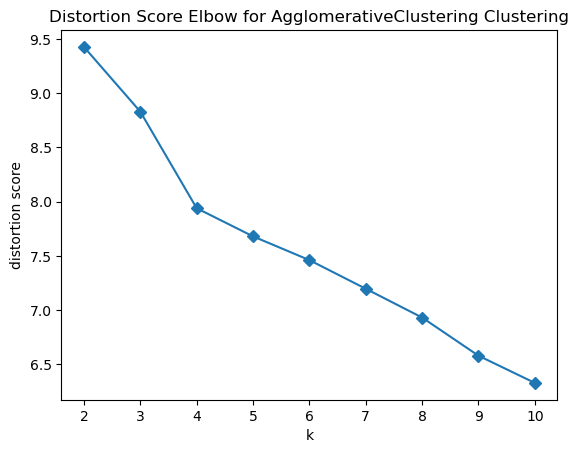

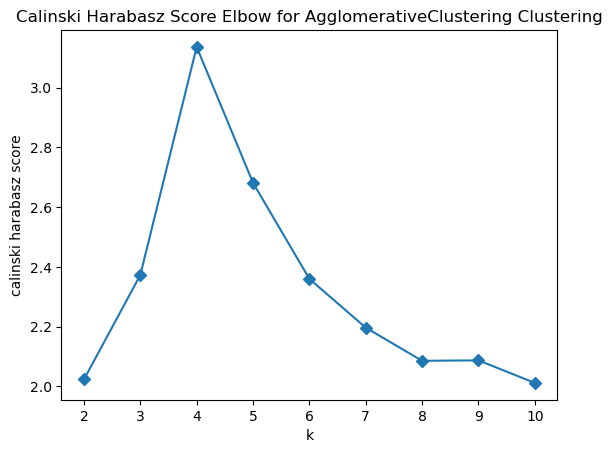

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [194]:
model = AgglomerativeClustering(affinity="precomputed", linkage="average")
visualizer = KElbowVisualizer(
    model, k=10, metric="silhouette", timings=False, locate_elbow=False
)

visualizer.fit(wdist_fold2)
ax = visualizer.show()

visualizer = KElbowVisualizer(
    model, k=10, metric="distortion", timings=False, locate_elbow=False
)

visualizer.fit(wdist_fold2)
ax = visualizer.show()

visualizer = KElbowVisualizer(
    model, k=10, metric="calinski_harabasz", timings=False, locate_elbow=False
)

visualizer.fit(wdist_fold2)
ax = visualizer.show()

We find the optimal number of clusters to be four as this solution maximizes the Calinski-Harabasz score.

In [206]:
model = AgglomerativeClustering(n_clusters=4, affinity="precomputed", linkage="average")
cluster_labels = model.fit_predict(wdist_fold2)
cluster_dict = {}
for cluster_label in np.unique(cluster_labels):
    cluster_dict[cluster_label] = list(
        np.array(list(wdist_fold0.index))[cluster_labels == cluster_label]
    )
for k, v in cluster_dict.items():
    print("Cluster {}: {}".format(k, v))
    print("")

Cluster 0: ['CEBPA', 'ELK1', 'ERG', 'JUN']

Cluster 1: ['BCL2L11', 'CASP8']

Cluster 2: ['AKT1S1', 'BRAF', 'CDC42', 'CDKN1A', 'CXXC4', 'DIABLO', 'EMPTY', 'FGFR3', 'FOXO1', 'GLI1', 'HRAS', 'MAP2K3', 'MAP3K2', 'MAP3K5', 'MAP3K9', 'MAPK7', 'MOS', 'MYD88', 'PIK3R2', 'PRKACA', 'PRKCE', 'RAF1', 'RELB', 'RHOA', 'SMO', 'SRC', 'SREBF1', 'TRAF2', 'WWTR1']

Cluster 3: ['ATF4', 'BAX', 'CREB1', 'E2F1', 'IRAK4', 'SMAD4', 'TSC2']



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/home/paysan_d/miniconda3/envs/image2reg/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


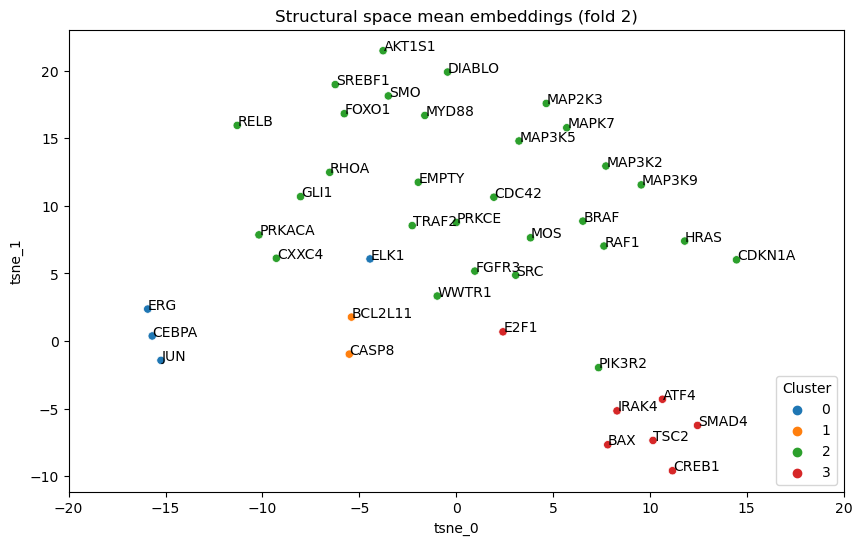

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [208]:
mean_fold2_latents = latents_fold2.groupby("labels").mean()
fig, ax = plt.subplots(figsize=[10, 6])
ax = plot_tsne_embs(
    mean_fold2_latents,
    ax=ax,
    perplexity=10,
    random_state=1234,
    hue=np.array(cluster_labels).astype(str),
    hue_order=np.unique(cluster_labels).astype(str),
)
ax.set_title("Structural space mean embeddings (fold 2)")
ax.set_xlim([-20, 20])
ax.legend(title="Cluster", loc="lower right")
plt.show()

---

##### Fold 3

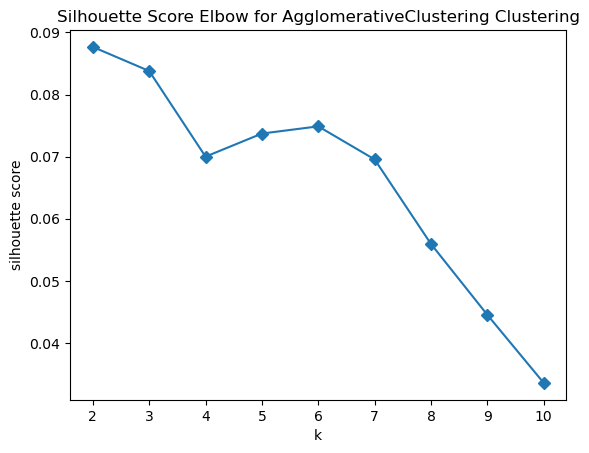

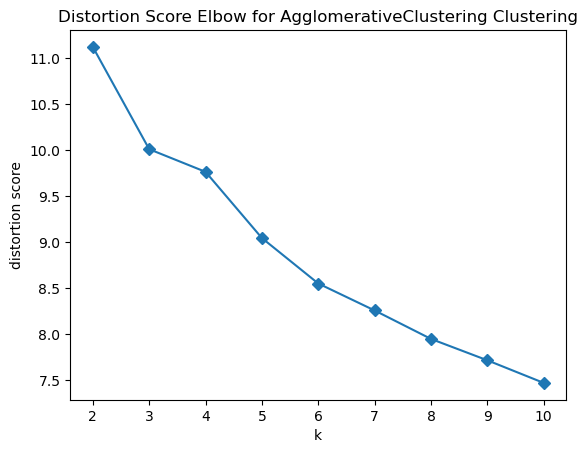

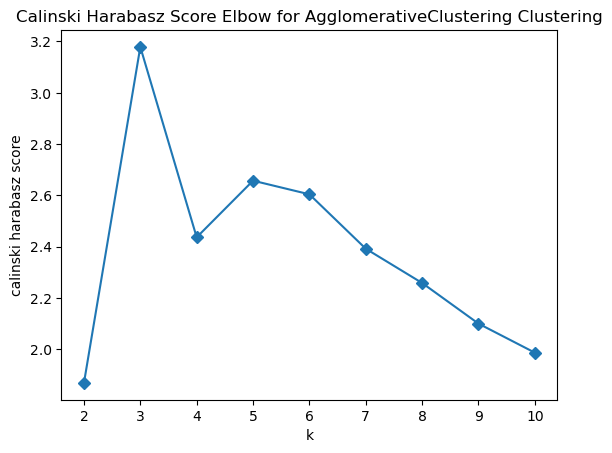

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [201]:
model = AgglomerativeClustering(affinity="precomputed", linkage="average")
visualizer = KElbowVisualizer(
    model, k=10, metric="silhouette", timings=False, locate_elbow=False
)

visualizer.fit(wdist_fold3)
ax = visualizer.show()

visualizer = KElbowVisualizer(
    model, k=10, metric="distortion", timings=False, locate_elbow=False
)

visualizer.fit(wdist_fold3)
ax = visualizer.show()

visualizer = KElbowVisualizer(
    model, k=10, metric="calinski_harabasz", timings=False, locate_elbow=False
)

visualizer.fit(wdist_fold3)
ax = visualizer.show()

We find the optimal number of clusters to be three as this solution maximizes the Calinski-Harabasz score.

In [202]:
model = AgglomerativeClustering(n_clusters=3, affinity="precomputed", linkage="average")
cluster_labels = model.fit_predict(wdist_fold3)
cluster_dict = {}
for cluster_label in np.unique(cluster_labels):
    cluster_dict[cluster_label] = list(
        np.array(list(wdist_fold0.index))[cluster_labels == cluster_label]
    )
for k, v in cluster_dict.items():
    print("Cluster {}: {}".format(k, v))
    print("")

Cluster 0: ['CASP8', 'HRAS']

Cluster 1: ['AKT1S1', 'BCL2L11', 'BRAF', 'CDC42', 'CEBPA', 'CXXC4', 'DIABLO', 'E2F1', 'ELK1', 'EMPTY', 'ERG', 'FGFR3', 'FOXO1', 'GLI1', 'JUN', 'MAP2K3', 'MAP3K2', 'MAP3K5', 'MAP3K9', 'MAPK7', 'MOS', 'MYD88', 'PRKACA', 'PRKCE', 'RAF1', 'RELB', 'RHOA', 'SMO', 'SRC', 'SREBF1', 'TRAF2', 'WWTR1']

Cluster 2: ['ATF4', 'BAX', 'CDKN1A', 'CREB1', 'IRAK4', 'PIK3R2', 'SMAD4', 'TSC2']



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/home/paysan_d/miniconda3/envs/image2reg/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


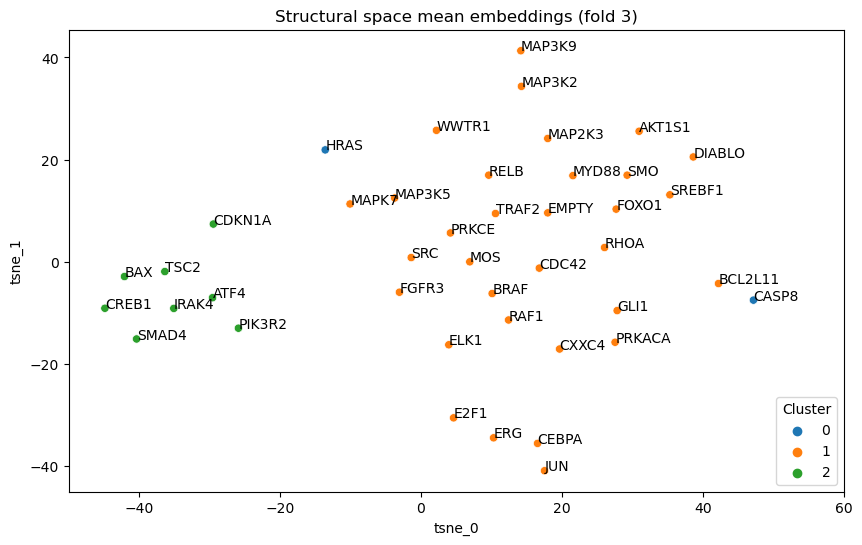

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [205]:
mean_fold3_latents = latents_fold3.groupby("labels").mean()
fig, ax = plt.subplots(figsize=[10, 6])
ax = plot_tsne_embs(
    mean_fold3_latents,
    ax=ax,
    perplexity=10,
    random_state=1234,
    hue=np.array(cluster_labels).astype(str),
    hue_order=np.unique(cluster_labels).astype(str),
)
ax.set_title("Structural space mean embeddings (fold 3)")
ax.set_xlim([-50, 60])
ax.legend(title="Cluster", loc="lower right")
plt.show()

---

---



### 3.3 Co-clustering of structural and regulatory spaces.

As shown above while the co-clustering is clearly not random as expected there are some difference of which regulators co-cluster depending on which held-out data set we assess.

We are interested in understanding how those different embeddings co-cluster with the regulatory space that we inferred from scRNA-seq and interactome data. To this end, we load the respective data and the previously identified cluster labels.

In [337]:
reg_embs = pd.read_csv(
    "../../../data/ppi/embedding/node_embeddings_cv_1024_2gexrecon_1graphrecon_mask_loss_newnodeset.csv",
    index_col=0,
)
reg_embs_clusters = pd.read_csv(
    "../../../data/ppi/embedding/node_embeddings_cv_1024_2gexrecon_1graph_recon_mask_loss_newnodeset_clusters.csv",
    index_col=0,
)
shared_nodes = set(reg_embs.index).intersection(wdist_fold0.index)
filtered_reg_embs = reg_embs.loc[shared_nodes]
filtered_wdist_fold0 = wdist_fold0.loc[shared_nodes, shared_nodes]
filtered_reg_embs_clusters = reg_embs_clusters.loc[shared_nodes]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

We are interested in understanding how similar the structure of the latent spaces is. To this end, we will look at the local neighborhoods for each gene in the two neighborhoods and assess whether or not those are part of the same cluster that is identified in the regulatory space. The corresponding "topk cluster agreement score" will be baselined using a permutation test, where we randomly distribute the cluster labels in both spaces.

Note that we restrict both spaces to the subset of genes that is covered in both for the consecutive analysis.

As a first step we compute the set of k-nearest neighbors for each gene covered in both spaces.

In [367]:
reg_neighbor_dict = get_neighbor_dict(filtered_reg_embs)
struct_neighbor_dict = get_neighbor_dict(filtered_wdist_fold0, metric="precomputed")
# struct_neighbor_dict = get_neighbor_dict(mean_fold3_latents.loc[shared_nodes])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [368]:
samples, struct_topks, reg_topks = assess_cluster_topk(
    reg_neighbor_dict, struct_neighbor_dict, filtered_reg_embs_clusters
)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [369]:
perm_struct_topks = []
np.random.seed(1234)
for i in tqdm(range(1000)):
    perm_cluster_labels = np.random.permutation(np.array(filtered_reg_embs_clusters))
    perm_clusters = pd.DataFrame(
        perm_cluster_labels, index=filtered_reg_embs_clusters.index, columns=["cluster"]
    )
    _, struct_topks, _ = assess_cluster_topk(
        reg_neighbor_dict, struct_neighbor_dict, perm_clusters
    )
    perm_struct_topks.append(struct_topks.mean(axis=0))

  0%|          | 0/1000 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

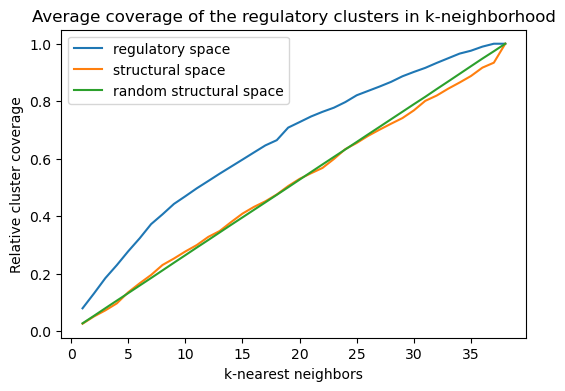

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [374]:
fig, ax = plt.subplots(figsize=[6, 4])
ax.plot(
    list(range(1, len(reg_topks) + 1)), reg_topks.mean(axis=0), label="regulatory space"
)
ax.plot(
    list(range(1, len(struct_topks) + 1)),
    struct_topks.mean(axis=0),
    label="structural space",
)
ax.plot(
    list(range(1, len(struct_topks) + 1)),
    np.array(perm_struct_topks).mean(axis=0),
    label="random structural space",
)
ax.legend()
ax.set_xlabel("k-nearest neighbors")
ax.set_ylabel("Relative cluster coverage")
ax.set_title("Average coverage of the regulatory clusters in k-neighborhood")
plt.show()

---

We will compute the co-clustering performance as measured by the mutual information and adjusted mutual information for each fold as well a corresponding background distribution established via permuting the cluster labels for both the network and structural embeddings randomly 100 times. This will be used as a Monte-Carlo approximation of the null hypothesis were the cluster assignments given a fixed number of clusters and cluster frequency in each space are completely independent as described in [Frank & Witten (1998)](https://researchcommons.waikato.ac.nz/handle/10289/1506).

##### Mutual information

In [46]:
mi_test_results = get_perm_test_results(
    fold_latents, node_embs_128, shared_nodes, score="mi"
)

100%|██████████| 200/200 [00:48<00:00,  4.14it/s]


<IPython.core.display.Javascript object>

The figures below show the co-clustering as assessed by the MC p-values for each fold individually.

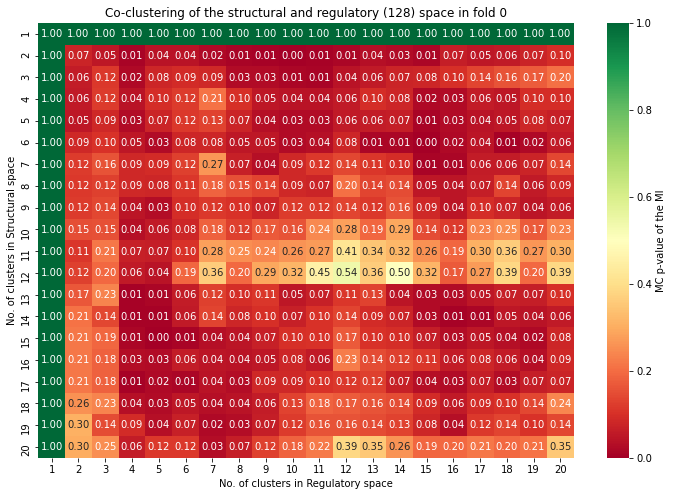

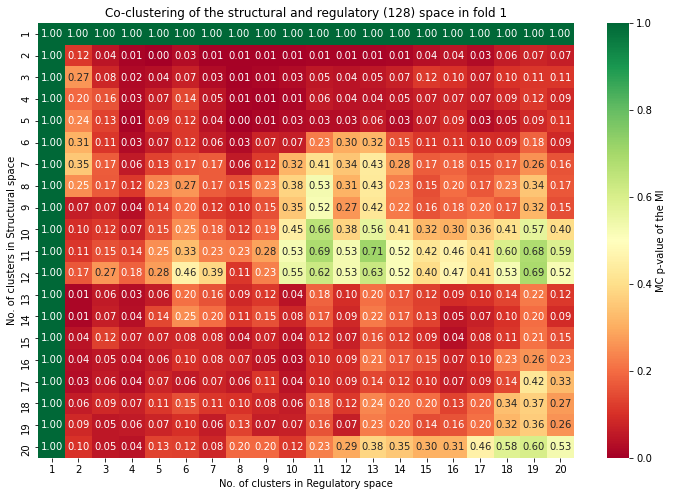

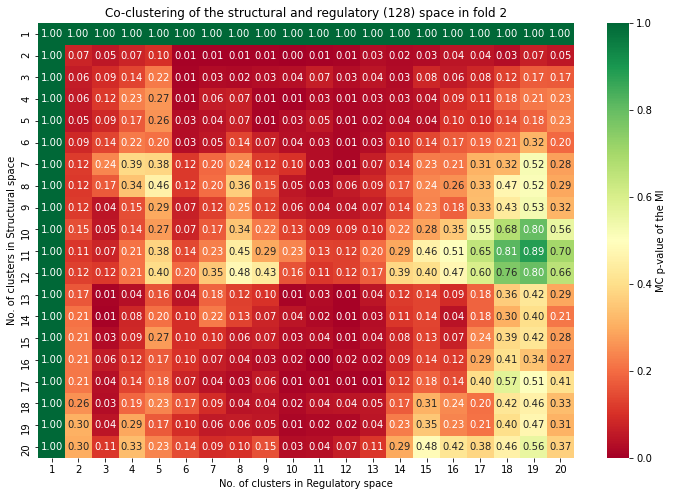

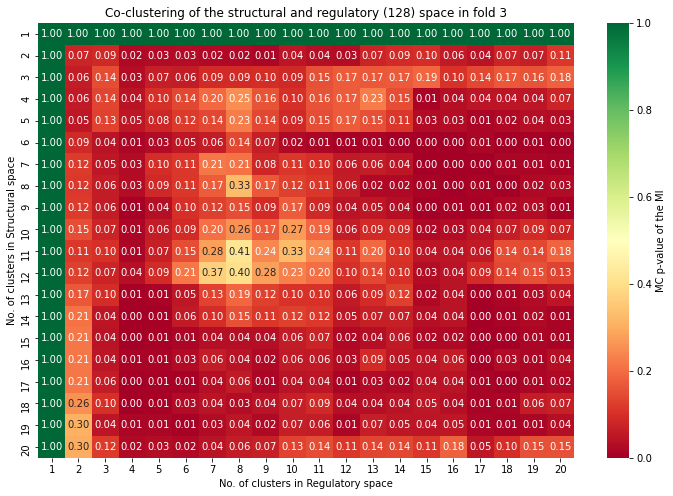

<IPython.core.display.Javascript object>

In [47]:
for i in range(len(mi_test_results["pval"])):
    plot_cc_score(
        mi_test_results["pval"][i],
        "Co-clustering of the structural and regulatory (128) space in fold {}".format(
            i
        ),
        "MC p-value of the MI",
        space_names=["Regulatory space", "Structural space"],
        figsize=[12, 8],
    )

We see that there is quite some variation of the p-values for the co-clustering suggesting a significant dependence of the clustering of the imaging space dependent on which data was held-out for validation. Nonetheless, we also observe a large number of significant p-values for different co-clustering solutions. Note, that those p values are not corrected for multiple testing.

##### Adjusted Mutual Information

In [48]:
ami_test_results = get_perm_test_results(
    fold_latents, node_embs_128, shared_nodes, score="ami"
)

100%|██████████| 200/200 [01:43<00:00,  1.93it/s]


<IPython.core.display.Javascript object>

We observe a fairly similar picture when using the adjusted mutual information, which is not surprising as the AMI is simply a transformed version of the MI adjusted for chance. To jointly summarize the strength of the co-clustering in the different folds, we look at the average adjusted mutual information for varying numbers of clusters across the four different held-out data sets.

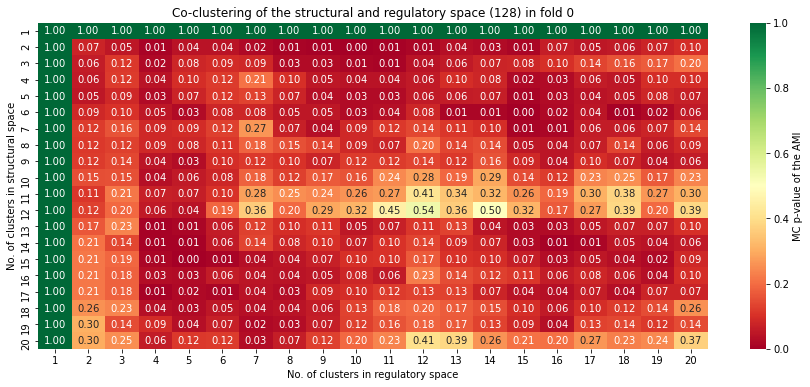

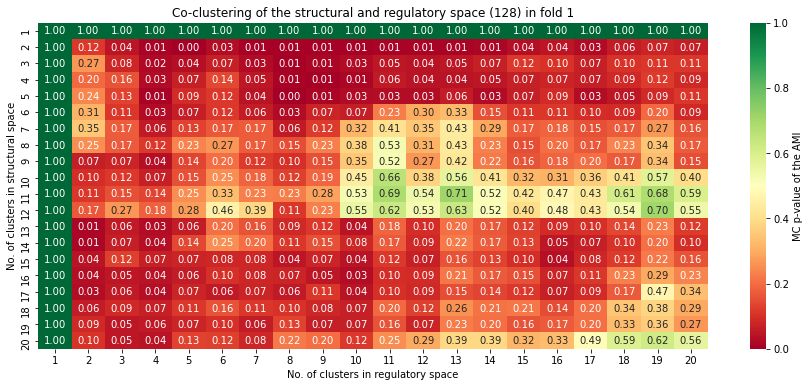

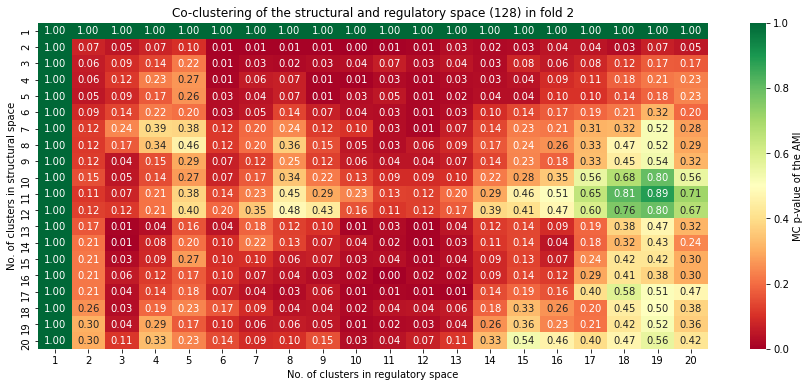

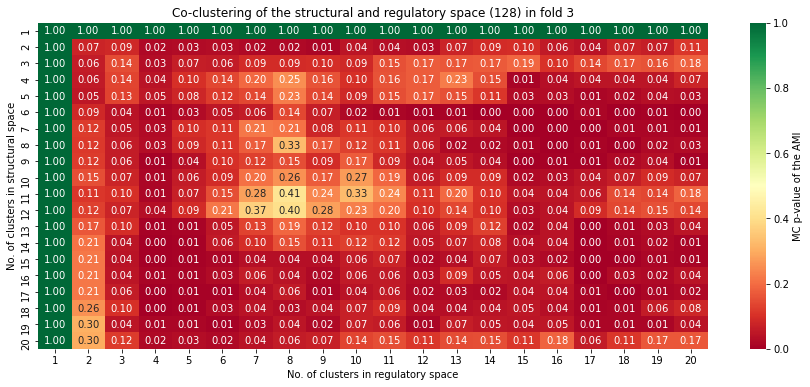

<IPython.core.display.Javascript object>

In [49]:
for i in range(len(ami_test_results["pval"])):
    plot_cc_score(
        ami_test_results["pval"][i],
        "Co-clustering of the structural and regulatory space (128) in fold {}".format(
            i
        ),
        "MC p-value of the AMI",
        space_names=["regulatory space", "structural space"],
    )

Note that the p-values define the approximate probability of the (adjusted) MI to be at least as large as in the observed co-clustering structure given the number of clusters and their relative frequencies. In practice this conditioning might be too strong for our use case as while the number of clusters differ an agreement in the relative cluster frequencies provide some information about the structure of the latent space that might or might not be present and thus is rather a characteristic that should be varied by chance as well.


---